### 1.Forecast the Airlines Passengers data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [3]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

In [8]:
airline = pd.read_excel('Airlines+Data.xlsx')
airline.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [9]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [10]:
airline.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [11]:
airline.isnull().sum()

Month         0
Passengers    0
dtype: int64

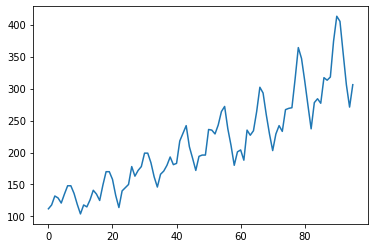

In [14]:
airline.Passengers.plot()
plt.show()

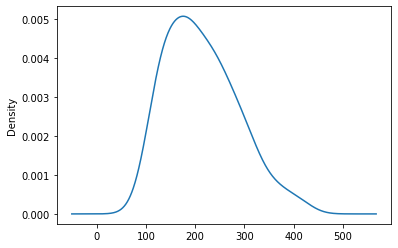

In [15]:
airline.Passengers.plot(kind='kde')
plt.show()

In [16]:
airline.rename(columns={'Month':'Date'},inplace=True)

In [25]:
airline.columns

Index(['Date', 'Passengers'], dtype='object')

In [26]:
airline['Month'] = airline.Date.dt.strftime('%b')
airline['Year'] = airline.Date.dt.strftime('%y')
airline['Day'] = airline.Date.dt.strftime('%d')

In [27]:
airline.head()

,Date,Passengers,Month,Year,Day
0,1995-01-01,112,Jan,95,01
1,1995-02-01,118,Feb,95,01
2,1995-03-01,132,Mar,95,01
3,1995-04-01,129,Apr,95,01
4,1995-05-01,121,May,95,01


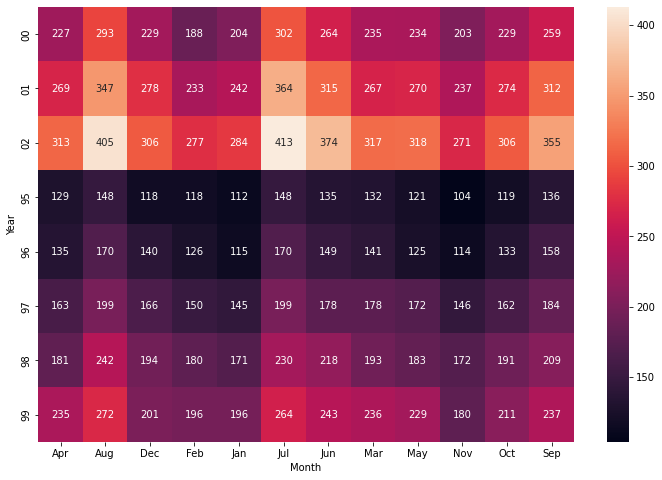

In [28]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=airline, values='Passengers', index='Year', columns='Month',aggfunc='mean' , fill_value=0)
sns.heatmap(heatmap_y_month, annot=True, fmt='g')
plt.show();

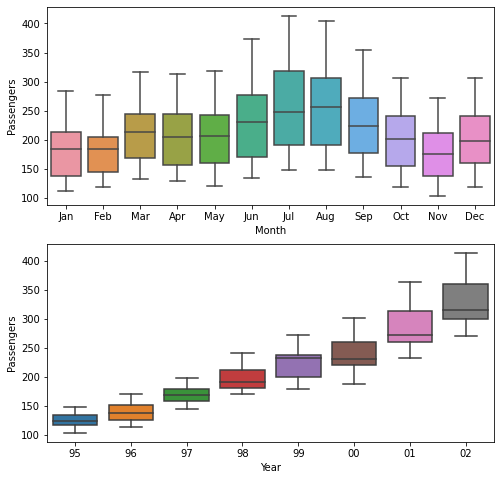

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(211)
sns.boxplot(x='Month',y='Passengers',data=airline)
plt.subplot(212)
sns.boxplot(x='Year', y='Passengers', data=airline)
plt.show();

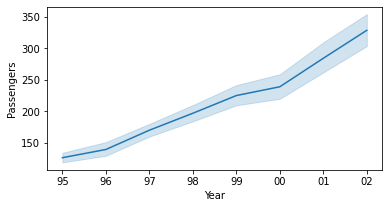

In [30]:
plt.figure(figsize=(6,3))
sns.lineplot(x='Year', y='Passengers', data=airline)
plt.show()

In [31]:
airline['t']= np.arange(0,96)
airline['t_square']= airline['t']*airline['t']
airline['log_Passengers']= np.log(airline['Passengers'])

In [33]:
month = pd.get_dummies(airline['Month'])
month

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,1,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,0,1
93,0,0,0,0,0,0,0,0,0,0,1,0
94,0,0,0,0,0,0,0,0,0,1,0,0


In [34]:
airline1 = pd.concat([airline, month], axis=1)
airline1.head()

,Date,Passengers,Month,Year,Day,t,t_square,log_Passengers,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,95,01,0,0,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,95,01,1,1,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,95,01,2,4,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,95,01,3,9,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,95,01,4,16,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


In [35]:
Train = airline1.head(80)
Test = airline1.tail(16)

## Linear Model

In [36]:
linear_model = smf.ols('Passengers~t', data=Train).fit()
pred_linear = pd.Series(linear_model.predict(Test['t']))
rmse_linear = np.sqrt(mean_squared_error(Test['Passengers'],pred_linear))
rmse_linear

47.54262406772675

## Exponential Model

In [38]:
exp_model = smf.ols('log_Passengers~t', data=Train).fit()
pred_exp = pd.Series(exp_model.predict(pd.DataFrame(Test['t'])))
rmse_exp = np.sqrt(mean_squared_error(Test['Passengers'],np.exp(pred_exp)))
rmse_exp

43.79373939334322

## Quadratic Model

In [39]:
quad_model = smf.ols('Passengers~t+t_square', data=Train).fit()
pred_quad = pd.Series(quad_model.predict(Test))
rmse_quad = np.sqrt(mean_squared_error(Test['Passengers'],pred_quad))
rmse_quad

43.65440369584217

## Additive Seasonality Model

In [40]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', data=Train).fit()
pred_add_sea = add_sea.predict(Test)
rmse_add_sea = np.sqrt(mean_squared_error(Test['Passengers'],pred_add_sea))
rmse_add_sea

129.26647641443313

## Additive seasonality Quadratic model

In [41]:
add_sea_quad = smf.ols('Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', data=Train).fit()
pred_add_sea_quad = add_sea_quad.predict(Test)
rmse_add_sea_quad = np.sqrt(mean_squared_error(Test['Passengers'],pred_add_sea_quad))
rmse_add_sea_quad

23.910983570093343

## Multiplicative Seasonality model

In [42]:
mult_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', data=Train).fit()
pred_mult_sea = mult_sea.predict(Test)
rmse_mult_sea = np.sqrt(mean_squared_error(Test['Passengers'],np.exp(pred_mult_sea)))
rmse_mult_sea

135.32648414621121

## Multiplicative Additive Seasonality model

In [43]:
mult_add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', data=Train).fit()
pred_mult_add_sea = mult_add_sea.predict(Test)
rmse_mult_add_sea = np.sqrt(mean_squared_error(Test['Passengers'],np.exp(pred_mult_add_sea)))
rmse_mult_add_sea

9.46900023037094

In [44]:
data = {"Model": (["rmse_linear","rmse_exp","rmse_quad","rmse_add_sea","rmse_add_sea_quad","rmse_mult_sea","rmse_mult_add_sea"]),
       "RMSE values":([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse = pd.DataFrame(data=data)
table_rmse.sort_values('RMSE values')

,Model,RMSE values
6,rmse_mult_add_sea,9.469000
4,rmse_add_sea_quad,23.910984
2,rmse_quad,43.654404
1,rmse_exp,43.793739
0,rmse_linear,47.542624
3,rmse_add_sea,129.266476
5,rmse_mult_sea,135.326484


In [45]:
airline_full = airline1
airline_full.head()

,Date,Passengers,Month,Year,Day,t,t_square,log_Passengers,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,95,01,0,0,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,95,01,1,1,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,95,01,2,4,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,95,01,3,9,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,95,01,4,16,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


In [46]:
final_model = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', data=airline_full).fit()

In [47]:
t = np.arange(97,108)
t

array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107])

In [48]:
t_square = t*t
t_square

array([ 9409,  9604,  9801, 10000, 10201, 10404, 10609, 10816, 11025,
       11236, 11449])

In [49]:
Month = pd.date_range(start='1/1/2003', end='11/1/2003', freq='MS')
Month

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01', '2003-11-01'],
              dtype='datetime64[ns]', freq='MS')

In [50]:
Month_df = pd.DataFrame(Month)
Month_df

,0
0,2003-01-01
1,2003-02-01
2,2003-03-01
3,2003-04-01
4,2003-05-01
5,2003-06-01
6,2003-07-01
7,2003-08-01
8,2003-09-01
9,2003-10-01


In [51]:
df = {'t':t, 't_square': t_square}
df = pd.DataFrame(df)
df

,t,t_square
0,97,9409
1,98,9604
2,99,9801
3,100,10000
4,101,10201
5,102,10404
6,103,10609
7,104,10816
8,105,11025
9,106,11236


In [52]:
new_data = pd.concat([Month_df, df],axis=1)
new_data

,0,t,t_square
0,2003-01-01,97,9409
1,2003-02-01,98,9604
2,2003-03-01,99,9801
3,2003-04-01,100,10000
4,2003-05-01,101,10201
5,2003-06-01,102,10404
6,2003-07-01,103,10609
7,2003-08-01,104,10816
8,2003-09-01,105,11025
9,2003-10-01,106,11236


In [53]:
new_data['Month']= new_data.iloc[:,0].dt.strftime('%b')
new_data['Year']= new_data.iloc[:,0].dt.strftime('%y')
new_data['Day']= new_data.iloc[:,0].dt.strftime('%d')
new_data

,0,t,t_square,Month,Year,Day
0,2003-01-01,97,9409,Jan,03,01
1,2003-02-01,98,9604,Feb,03,01
2,2003-03-01,99,9801,Mar,03,01
3,2003-04-01,100,10000,Apr,03,01
4,2003-05-01,101,10201,May,03,01
5,2003-06-01,102,10404,Jun,03,01
6,2003-07-01,103,10609,Jul,03,01
7,2003-08-01,104,10816,Aug,03,01
8,2003-09-01,105,11025,Sep,03,01
9,2003-10-01,106,11236,Oct,03,01


In [54]:
month_dummy = pd.get_dummies(new_data['Month'])
month_dummy

,Apr,Aug,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,1,0


In [55]:
predict_data = pd.concat([new_data,month_dummy],axis=1)

In [56]:
predict_data.rename(columns={0:'Date'}, inplace=True)

In [57]:
predict_data

,Date,t,t_square,Month,Year,Day,Apr,Aug,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2003-01-01,97,9409,Jan,03,01,0,0,0,1,0,0,0,0,0,0,0
1,2003-02-01,98,9604,Feb,03,01,0,0,1,0,0,0,0,0,0,0,0
2,2003-03-01,99,9801,Mar,03,01,0,0,0,0,0,0,1,0,0,0,0
3,2003-04-01,100,10000,Apr,03,01,1,0,0,0,0,0,0,0,0,0,0
4,2003-05-01,101,10201,May,03,01,0,0,0,0,0,0,0,1,0,0,0
5,2003-06-01,102,10404,Jun,03,01,0,0,0,0,0,1,0,0,0,0,0
6,2003-07-01,103,10609,Jul,03,01,0,0,0,0,1,0,0,0,0,0,0
7,2003-08-01,104,10816,Aug,03,01,0,1,0,0,0,0,0,0,0,0,0
8,2003-09-01,105,11025,Sep,03,01,0,0,0,0,0,0,0,0,0,0,1
9,2003-10-01,106,11236,Oct,03,01,0,0,0,0,0,0,0,0,0,1,0


In [58]:
pred_final = final_model.predict(predict_data)

In [59]:
forecast_passengers = np.exp(pred_final)
forecast_passengers

0     324.401579
1     327.833787
2     378.299321
3     366.073228
4     363.693142
5     411.641432
6     457.788313
7     456.820392
8     409.137573
9     359.221716
10    315.288898
dtype: float64

In [61]:
predict_data['forecast_passengers'] = pd.Series(forecast_passengers)
predict_data

,Date,t,t_square,Month,Year,Day,Apr,Aug,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,forecast_passengers
0,2003-01-01,97,9409,Jan,03,01,0,0,0,1,0,0,0,0,0,0,0,324.401579
1,2003-02-01,98,9604,Feb,03,01,0,0,1,0,0,0,0,0,0,0,0,327.833787
2,2003-03-01,99,9801,Mar,03,01,0,0,0,0,0,0,1,0,0,0,0,378.299321
3,2003-04-01,100,10000,Apr,03,01,1,0,0,0,0,0,0,0,0,0,0,366.073228
4,2003-05-01,101,10201,May,03,01,0,0,0,0,0,0,0,1,0,0,0,363.693142
5,2003-06-01,102,10404,Jun,03,01,0,0,0,0,0,1,0,0,0,0,0,411.641432
6,2003-07-01,103,10609,Jul,03,01,0,0,0,0,1,0,0,0,0,0,0,457.788313
7,2003-08-01,104,10816,Aug,03,01,0,1,0,0,0,0,0,0,0,0,0,456.820392
8,2003-09-01,105,11025,Sep,03,01,0,0,0,0,0,0,0,0,0,0,1,409.137573
9,2003-10-01,106,11236,Oct,03,01,0,0,0,0,0,0,0,0,0,1,0,359.221716


### 2. Forecast the CocaCola prices data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [63]:
Cocacola = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
Cocacola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [64]:
Cocacola.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [65]:
Cocacola.isna().sum()

Quarter    0
Sales      0
dtype: int64

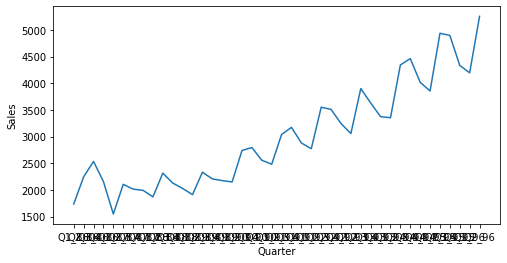

In [66]:
plt.figure(figsize=(8,4))
sns.lineplot(x='Quarter', y='Sales', data=Cocacola);

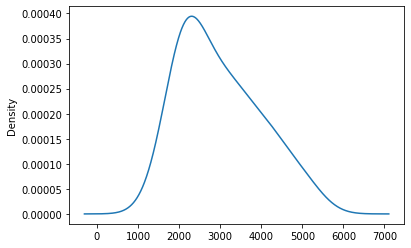

In [67]:
Cocacola.Sales.plot(kind='kde');

In [68]:
quarter = ['Q1','Q2','Q3','Q4']
Cocacola['quarter'] = 0
Cocacola['Year'] = 0

In [69]:
Cocacola.head()

,Quarter,Sales,quarter,Year
0,Q1_86,1734.827000,0,0
1,Q2_86,2244.960999,0,0
2,Q3_86,2533.804993,0,0
3,Q4_86,2154.962997,0,0
4,Q1_87,1547.818996,0,0


In [70]:
for i in range(42):
    n = Cocacola['Quarter'][i]
    Cocacola['quarter'][i] = n[0:2]
    Cocacola['Year'][i] = n[3:5]

In [71]:
Cocacola.head()

,Quarter,Sales,quarter,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [72]:
Cocacola['Year'] = pd.to_numeric(Cocacola['Year'])

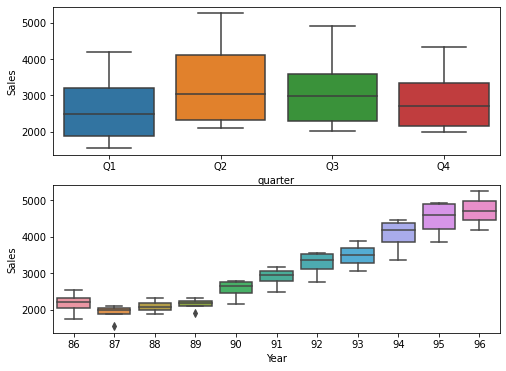

In [73]:
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x= 'quarter', y= 'Sales', data=Cocacola);
plt.subplot(212)
sns.boxplot(x= 'Year', y= 'Sales', data=Cocacola);

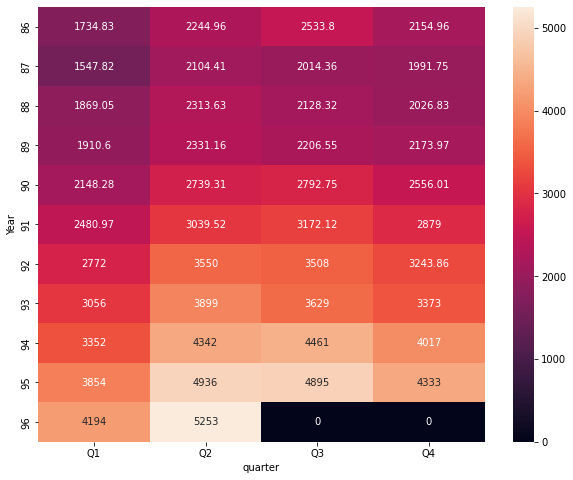

In [74]:
plt.figure(figsize=(10,8))
heatmap_pivot = pd.pivot_table( data=Cocacola, values='Sales', index='Year', columns='quarter', aggfunc='mean', fill_value=0)
sns.heatmap(heatmap_pivot, annot=True, fmt='g');

In [75]:
quarter_dummies = pd.get_dummies(Cocacola['quarter'])
quarter_dummies.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [76]:
Cocacola1 = pd.concat([Cocacola,quarter_dummies], axis=1)
Cocacola1.head()

,Quarter,Sales,quarter,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


In [77]:
Cocacola1['t'] = np.arange(1,43)
Cocacola1['t_square'] = Cocacola1['t']*Cocacola1['t']
Cocacola1['log_sales'] = np.log(Cocacola1['Sales'])

In [78]:
Cocacola1.head()

,Quarter,Sales,quarter,Year,Q1,Q2,Q3,Q4,t,t_square,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


In [79]:
Train = Cocacola1.head(30)
Test = Cocacola1.tail(12)

## Linear model

In [80]:
linear_model = smf.ols('Sales~t',Train).fit()
pred_linear = linear_model.predict(Test)
rmse_linear = np.sqrt(mean_squared_error(Test['Sales'], pred_linear))
rmse_linear

714.0144483281299

## Quadratic Model

In [81]:
quad_model = smf.ols('Sales~t+t_square',data=Train).fit()
pred_quad = quad_model.predict(Test)
rmse_quad = np.sqrt(mean_squared_error(Test['Sales'], pred_quad))
rmse_quad

646.2715428311304

## Exponential Model

In [82]:
exp_model = smf.ols('log_sales~t',data=Train).fit()
pred_exp = exp_model.predict(Test)
rmse_exp = np.sqrt(mean_squared_error(Test['Sales'],np.exp(pred_exp)))
rmse_exp

552.2821039079217

## Additive seasonality

In [83]:
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = add_sea.predict(Test)
rmse_add_sea = np.sqrt(mean_squared_error(Test['Sales'], pred_add_sea))
rmse_add_sea

1778.006546794136

## Additive seasonality Quadratic

In [85]:
add_sea_quad = smf.ols('Sales~t+t_square+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = add_sea_quad.predict(Test)
rmse_add_sea_quad = np.sqrt(mean_squared_error(Test['Sales'], pred_add_sea_quad))
rmse_add_sea_quad

586.053306787034

## Multiplicative Seasonality

In [86]:
mult_sea = smf.ols('log_sales~Q1+Q2+Q3',data=Train).fit()
pred_mult_sea = mult_sea.predict(Test)
rmse_mult_sea = np.sqrt(mean_squared_error(Test['Sales'], np.exp(pred_mult_sea)))
rmse_mult_sea

1828.9238912138119

## Multiplicative Additive Seasonality

In [87]:
mult_add_sea = smf.ols('log_sales~t+Q1+Q2+Q3',data=Train).fit()
pred_mult_add_sea = mult_add_sea.predict(Test)
rmse_mult_add_sea = np.sqrt(mean_squared_error(Test['Sales'], np.exp(pred_mult_add_sea)))
rmse_mult_add_sea

410.2497059601741

In [88]:
data = pd.DataFrame({'Model':(["rmse_linear","rmse_exp","rmse_quad","rmse_add_sea","rmse_add_sea_quad","rmse_mult_sea","rmse_mult_add_sea"]),
                    'RMSE value': ([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])})
data.sort_values('RMSE value')

,Model,RMSE value
6,rmse_mult_add_sea,410.249706
1,rmse_exp,552.282104
4,rmse_add_sea_quad,586.053307
2,rmse_quad,646.271543
0,rmse_linear,714.014448
3,rmse_add_sea,1778.006547
5,rmse_mult_sea,1828.923891


In [89]:
Final_model = smf.ols('log_sales~t+Q1+Q2+Q3',data=Cocacola1).fit()

In [90]:
new_data = [['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'],['Q2_97', 'Q2']]
print(new_data)

[['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'], ['Q2_97', 'Q2']]


In [91]:
forecast = pd.DataFrame(new_data, columns = ['Quarter', 'quarter'])
forecast

,Quarter,quarter
0,Q3_96,Q3
1,Q4_96,Q4
2,Q1_97,Q1
3,Q2_97,Q2


In [92]:
dummies = pd.get_dummies(forecast['quarter'])

In [93]:
forecast_df = pd.concat([forecast,dummies], axis=1)
forecast_df['t']= np.arange(1,5)
forecast_df['t_square']= forecast_df['t']*forecast_df['t']
forecast_df

,Quarter,quarter,Q1,Q2,Q3,Q4,t,t_square
0,Q3_96,Q3,0,0,1,0,1,1
1,Q4_96,Q4,0,0,0,1,2,4
2,Q1_97,Q1,1,0,0,0,3,9
3,Q2_97,Q2,0,1,0,0,4,16


In [94]:
pred_final =Final_model.predict(forecast_df)
forecasted_sales = np.exp(pred_final)
forecasted_sales

0    1850.097087
1    1707.728369
2    1615.755820
3    2055.102678
dtype: float64

In [95]:
forecast_df['forecasted_sales']= pd.DataFrame(forecasted_sales)
forecast_df

,Quarter,quarter,Q1,Q2,Q3,Q4,t,t_square,forecasted_sales
0,Q3_96,Q3,0,0,1,0,1,1,1850.097087
1,Q4_96,Q4,0,0,0,1,2,4,1707.728369
2,Q1_97,Q1,1,0,0,0,3,9,1615.755820
3,Q2_97,Q2,0,1,0,0,4,16,2055.102678
